<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/barebones_tsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [433]:
# -*- coding: utf-8 -*-
"""
@author: Dr. Fayyaz Minhas
2D Scatter Plotter for Classification
"""
from numpy.random import randn #importing randn
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None or len(conts)<2:
            #conts = list(classes)
            vmin,vmax = classes[0]-eps,classes[-1]+eps
        else:            
            vmin,vmax= np.min(conts)-eps,np.max(conts)+eps
        
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None or len(conts)<2:            
            conts = sorted([-1+eps,0,1-eps])
        else:
            vmin,vmax= np.min(conts)-eps,np.max(conts)+eps
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)
        
        z = np.reshape(z,(npts,npts)).T        
        
        
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)
    
    if Y is not None:        
        for i,y in enumerate(classes):
            
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 50)     
         
    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()
    return extent


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


'\ndef clf(inputs): \n  return inputs@wb\n\nprint("Predictions: ",clf(inputs))\nprint("Weights: ",wbn)\nplt.figure()\n\n\nplotit(inputs,targets,clf=clf,conts=[0],extent = [-5,+5,-5,+5])\n'

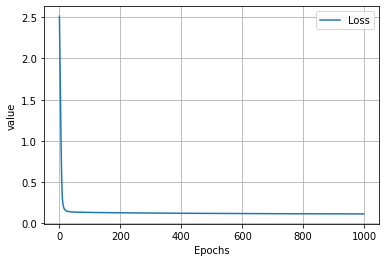

In [434]:
"""
Author: Fayyaz Minhas
A barebones single neuron model example with pytorch
You will need plotit for this (https://github.com/foxtrotmike/plotit)
Demonstrates: 
    Representation, Evaluation and Optimization
    concept of loss functions, SRM objective function
    automatic differentiation
    optimization
Things to try: What happens if you:
    change the input from bipolar to binary
    change the targets from bipolar to binary
    change the loss function
    change the activation function
    change the regularization parameter
    can solve a linearly inseparable classification problem
"""
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.modules as nn
import torch.optim as optim

#Let's generate some data
#inputs = 2*np.array([[0,0],[0,1],[1,0],[1,1]],dtype=np.float)-1
#targets = np.array([-1,-1,-1,1],dtype=np.float)
inputs = np.array([[-1.0,0],[0,1],[4,4],[2,3]])
targets = np.array([-1,-1,+1,+1])

Xp = 1.0+np.random.randn(100,2); Xn = -1.0-np.random.randn(100,2);
inputs = np.vstack((Xp,Xn))	
targets = np.hstack((np.ones(len(Xp)),-np.ones(len(Xn))))
ttargets = targets+0
targets[0:]=np.nan; 
targets[0]=1.0;
targets[-1]=-1.0
K = (np.dot(inputs,inputs.T)+1)**2
from sklearn.metrics.pairwise import rbf_kernel
K = rbf_kernel(inputs)
K = torch.from_numpy(K).float() #kernel
device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
x = torch.from_numpy(inputs).float()
y = torch.from_numpy(targets).float()
N, D_in,D_out = x.shape[0], x.shape[1], 1
# Loss function implementation
def L1(z):
    g = 5
    zz = torch.zeros((2,len(z)))
    zz[1] = 1-z    
    closs = torch.logsumexp(g*zz,0)/g
    return closs
def L2(z):
    g = 5
    zz = torch.zeros((2,len(z)))
    zz[1] = z
    az = (torch.logsumexp(-g*zz,0)+torch.logsumexp(g*zz,0))/g #smooth approximation of abs https://math.stackexchange.com/questions/728094/approximate-x-with-a-smooth-function
    #az = torch.logsumexp(g*zz,0)*2/g-z-(2/g)*torch.log(torch.tensor(2)) #smooth approximation of abs 
    zz[1] = 1-az    
    closs= torch.logsumexp(g*zz,0)/g #approx of max(0,1-abs(z))
    #closs = torch.exp(-3*(z**2)) #original approximation used in the paper 
    #closs = torch.exp(-0.5*(z**2)) #original approximation used in the paper "LARGE SCALE TRANSDUCTIVE SVMS"  by Collobert 2006    
    #closs= torch.max(torch.Tensor([0]) , 1 - torch.abs(z)) 
    return closs

def hinge(z):
    zero = torch.Tensor([0]) 
    return torch.max(zero, 1 - z) 
def sq_loss(y_true,y_pred):
    return (y_true-y_pred)**2
def logistic_loss(y_true,y_pred):
    return torch.log(1+torch.exp(- y_true * y_pred))
# Other loss functions can also be implemented
eps = 1e-6
# Create random Tensors for weights; setting requires_grad=True means that we
# want to compute gradients for these Tensors during the backward pass.
wb = torch.randn(N, device=device, requires_grad=True)
wb = torch.tensor(torch.empty(N).normal_(mean=0,std=0.1), requires_grad=True)
#Note: we have added one additional weight (for bias)
learning_rate = 1e-2
lambda_w = 1e-2
lambda_u = 1e-1
optimizer = optim.SGD([wb], lr=learning_rate)
L = [] #history of losses
uidx = torch.isnan(y)
pidx = y==1
nidx = y==-1
loss_s = 0.0
loss_u = 0.0
n_unsupv = torch.sum(uidx)
n_pos = torch.sum(pidx)
n_neg = torch.sum(nidx)
for epoch in range(1000):
      """
      # REPRESENTATION
      """
      y_pred = wb@K
      """
      # EVALUATION
      """
      # Compute and print loss. Loss is a Tensor of shape (), and loss.item()
      # is a Python number giving its value.
      #loss = (y_pred - y).pow(2).mean() #loss = lossf(y_pred,y) 
      loss_s = 0
      if n_pos:
        loss_s = torch.mean(L1(y_pred[pidx]))
      if n_neg:
        loss_s+=torch.mean(L1(-1*y_pred[nidx]))
      if n_unsupv:
        loss_u = torch.mean(L2(y_pred[uidx]))
      #loss = torch.mean(hinge(y,y_pred))
      obj = loss_s+lambda_u*loss_u+lambda_w*wb@K@wb#+0.0*torch.dot(wb,wb) #empirical loss + regularization
      #epoch_loss+=loss#.item()      

      """
      #OPTIMIZATION
      """
      # Use autograd to compute the backward pass. This call will compute the
      # gradient of loss with respect to all Tensors with requires_grad=True.
      # After this call w1.grad will be Tensors holding the gradient
      # of the loss with respect to w1.
      obj.backward()
    
      # Update weights using gradient descent. For this step we just want to mutate
      # the values of w1 in-place; we don't want to build up a computational
      # graph for the update steps, so we use the torch.no_grad() context manager
      # to prevent PyTorch from building a computational graph for the updates
      """
      with torch.no_grad():
          wb = wb - learning_rate * wb.grad
      wb.requires_grad = True
      """
      # Using built-in optimizer
      optimizer.step()
      optimizer.zero_grad()
      L.append(obj.detach().numpy()) #save for history and plotting

wbn = wb.detach().numpy()

plt.close("all")
plt.plot(L)
plt.grid(); plt.xlabel('Epochs'); plt.ylabel('value');plt.legend(['Loss','Objective'])
"""
def clf(inputs): 
  return inputs@wb

print("Predictions: ",clf(inputs))
print("Weights: ",wbn)
plt.figure()


plotit(inputs,targets,clf=clf,conts=[0],extent = [-5,+5,-5,+5])
"""

In [435]:
print("Accuracy",torch.sum((wb@K*torch.from_numpy(ttargets))>0)/len(y))

Accuracy tensor(0.9350)


(array([11., 18., 24., 25., 23., 18., 20., 23., 22., 16.]),
 array([-1.8323517 , -1.4752488 , -1.1181458 , -0.76104295, -0.40394002,
        -0.04683709,  0.31026584,  0.66736877,  1.0244716 ,  1.3815746 ,
         1.7386775 ], dtype=float32),
 <a list of 10 Patch objects>)

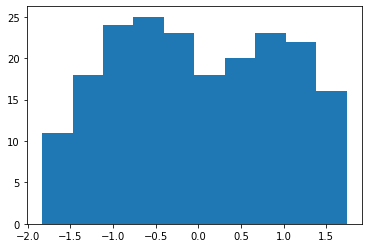

In [436]:
plt.hist(np.sort(y_pred.detach().numpy()))

(array([ 1.,  2.,  5., 21., 31., 43., 42., 34., 17.,  4.]),
 array([-0.39428303, -0.3277396 , -0.2611962 , -0.19465277, -0.12810935,
        -0.06156594,  0.00497748,  0.0715209 ,  0.13806432,  0.20460774,
         0.27115116], dtype=float32),
 <a list of 10 Patch objects>)

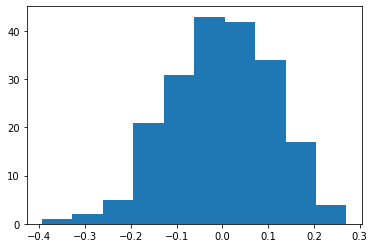

In [437]:
plt.hist(np.sort(wb.detach().numpy()))

In [438]:
y

tensor([ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n